# 02: Download lightcurve data 

# Imports


In [1]:
import os
from astropy.table import Table
import functions as func
from astroML.datasets import fetch_dr7_quasar
from astropy.table import Table
import matplotlib.pyplot as plt 

# Get SDSS QSO data 

The data is located at https://faculty.washington.edu/ivezic/macleod/qso_dr7/Southern.html 


In [1]:
url = "https://faculty.washington.edu/ivezic/macleod/qso_dr7/QSO_S82.tar.gz"
fpath = os.path.join(os.getcwd(), "QSO_S82.tar.gz")
if not os.path.exists(fpath):
    os.system(f'wget {url}')  

In [ ]:
! tar xzf QSO_S82.tar.gz

We confirm that all light curves are  there by testing that the number of files in the directory equals to the expected number of quasars:

In [2]:
assert len(os.listdir("QSO_S82")) == 9258

# Get PS1 QSO data: CLQSO candidates

One way is to query the user interface of the MAST archive given the ra,dec positions of  changing-look quasar  candidates. This is a subset of the 9258 quasars above, selected given their variability properties as described in Suberlak+2021. The table of candidates can be downloaded from https://iopscience.iop.org/0004-637X/907/2/96/suppdata/apjabc698t5_ascii.txt?doi=10.3847/1538-4357/abc698. I copy-paste the text into a text file (in the github repo) called "CLQSO_candidates.txt"

In [7]:
colnames = ['dbID', 'SDSSJID', 'ra', 'dec',	'Redshift', 'log10_Lbol', 'log10_MBH', 
            'f_Edd','Delta(mag)',
            'Delta(sigma_G)', 'MedianPS1']
clqso = Table.read("CLQSO_candidates.txt", format='ascii',
                   names=colnames)

In [8]:
len(clqso)

40

The MAST archive expects a csv file with the following structure:
    
    target     ra   dec 
    
    


In [12]:
# so we make one :
clqso[['SDSS_NAME','RA','DEC']].write('CLQSO_cans_ra_dec.csv', format='csv',
                                names=('target','ra','dec'),
                                overwrite=True)


On  https://catalogs.mast.stsci.edu/panstarrs/ we select  "Crossmatch a List of Targets " option. I save the table as CSV file CLQSO_candidates_PS1_DR2.csv:

In [46]:
ps1 = Table.read('CLQSO_candidates_PS1_DR2.csv', format='csv')

From https://outerspace.stsci.edu/display/PANSTARRS/PS1+Detection+table+fields I find that units of `psfFLux` are Janskys.

In [47]:
ps1['mag'] = func.flux2ab(ps1['psfFlux'])
ps1['magerr'] = func.flux2absigma(ps1['psfFlux'], ps1['psfFluxErr'])

/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/functions.py:391: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(flux) + 8.90
/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/functions.py:391: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + 8.90
/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/functions.py:380: RuntimeWarning: divide by zero encountered in true_divide
  return FIVE_OVER_2LOG10 * fluxsigma / flux


# Get PS1 QSO data:  a subset of SDSS S82 

Obtain the master catalog describing the SDSS S82 

In [2]:
path = os.getcwd()
file_path = os.path.join(path, "DB_QSO_S82.dat.gz")
if not os.path.exists(file_path):
    # Get the quasar catalog - it gets saved in the same directory as the notebook 
    url = "https://faculty.washington.edu/ivezic/macleod/qso_dr7/DB_QSO_S82.dat.gz"
    os.system(f'wget {url}')   

In [3]:
file_path = os.path.join(path, "DB_QSO_S82.dat.gz")

# we know the column meaning from
# https://faculty.washington.edu/ivezic/macleod/qso_dr7/Southern_format_DB.html
colnames = ["dbID","ra","dec","SDR5ID","M_i","M_i_corr",
"redshift","mass_BH","Lbol","u","g","r","i","z","Au",]
SDSS_DR7_S82 = Table.read(file_path, format="ascii", names=colnames)


This is a subset of what could be obtained from astroML: 

In [4]:

SDSS_DR7 = Table(fetch_dr7_quasar())
SDSS_DR7.rename_column('RA', 'ra')

Plot both the entire DR7 quasar database, and the Stripe82 subset:

Text(0.5, 1.0, 'SDSS DR7 Quasar Database')

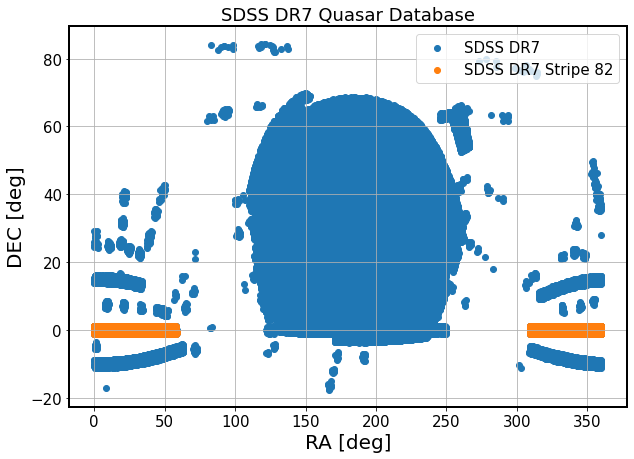

In [82]:
fig,ax = plt.subplots(1,1,figsize=(10,7))
ax.scatter(SDSS_DR7['ra'],  SDSS_DR7['dec'], label='SDSS DR7')
ax.scatter(SDSS_DR7_S82['ra'], SDSS_DR7_S82['dec'] , label = 'SDSS DR7 Stripe 82')
ax.grid()
ax.legend()
ax.set_xlabel('RA [deg]')
ax.set_ylabel('DEC [deg]')
ax.set_title('SDSS DR7 Quasar Database')

Create a list of 10 brightest objects:


In [5]:
SDSS_DR7_S82.sort('g',reverse=False)
m = SDSS_DR7_S82['g'] > 0
qso_select = SDSS_DR7_S82[m][:10]

Now identically to the above,  create a csv file with a format

    target   ra  dec  
    
that could be used to query PS1.  We can keep the dbId as the identifier, since in this case that's what we can use to find the appropriate SDSS light curve.

In [6]:
qso_ps1 =  qso_select[['dbID', 'ra','dec']]
qso_ps1.rename_column('dbID', 'target')
qso_ps1.write('ps1_top_10_brightest_S82.csv', format=
             'csv', overwrite=True)

Another way (that allows to more quickly save  the PS1 light curves) is to  submit queries directly https://catalogs.mast.stsci.edu/docs/panstarrs.html :

In [105]:
def get_PS1_lc(target, ra,dec, dr_path):
    radius = 3/3600. # 3 asec in degrees ; the default  
    pagesize = 5000 # default max length of LC 
    fname = f"{target}_PS1_DR2_detection.csv"
    file_path = os.path.join(dr_path, fname)
    if os.path.exists(file_path):
        print(f"File {file_path} already exists")
    else:
        ps1_url = "https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr2/detection.csv?"
        query_url = f"{ps1_url}ra={ra}&dec={dec}&radius={radius}&pagesize={pagesize}"
        cmd = f"wget -O {file_path} " + f'"{query_url}"'
        print(cmd)
        os.system(cmd)
        

The cell below executes the query using the new API for these targets and saves them in a `PS1_DR2_detection` sub-directory:

In [ ]:
dr_path = os.path.join(os.getcwd(), 'PS1_DR2_detection')
if not os.path.exists(dr_path):
    os.makedirs(dr_path)
    
for row in qso_ps1:
    target = row['target']
    ra = row['ra']
    dec = row['dec']
    get_PS1_lc(target, ra,dec, dr_path)

# Get ZTF QSO data 

## For CLQSO candidates

The ZTF DR7 data https://www.ztf.caltech.edu/ztf-public-releases.html  can be downloaded using the `wget`-based function written by Paula Sanchez-Saez here https://github.com/LSST-sersag/dle/blob/main/activities/workshop/T2_Photometric_Reverberation_Mapping/Tutorial%202_PhotoRM_IJ.ipynb . I modify it to do just the downloading, because I prefer to read the files with astropy. As of 4/5/2024, the most recent is DR20.  
A slight modification - instead of assuming a filename based on SDSS "jname",  use the name provided to the function. 

In [1]:
colnames = ['dbID', 'SDSSJID', 'ra', 'dec',	'Redshift', 'log10_Lbol', 'log10_MBH', 
            'f_Edd','Delta(mag)',
            'Delta(sigma_G)', 'MedianPS1']
# can read that if we're only downloading ZTF data...
clqso = Table.read("CLQSO_candidates.txt", format='ascii',
                   names=colnames)

In [ ]:
# check whether a file already exists...
dr_path = os.path.join(os.getcwd(), 'ZTFDR21')
if not os.path.exists(dr_path):
    os.makedirs(dr_path)
for row in qso_select:
    sdss_name = row['SDSSJID']
    jname = f'J{sdss_name}'
    ra = row['ra']
    dec = row['dec']
    for f in 'gri':
        file_name = f'{jname}_ZTF_{f}.csv'
        file_path = os.path.join(dr_path, file_name)
        # only query if it doesn't 
        if not os.path.exists(file_path):
            func.get_ZTF_lc(fname=file_name, 
                          ra=ra, 
                          dec=dec, 
                          band=f, 
                          dr_path=dr_path)


## For another subset of SDSS DR7 S82 (using dbID as fname)

In [9]:
import importlib as imp

In [10]:
imp.reload(func)

<module 'functions' from '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/functions.py'>

In [11]:
# check whether a file already exists...
dr_path = os.path.join(os.getcwd(), 'ZTFDR21')
if not os.path.exists(dr_path):
    os.makedirs(dr_path)
for row in qso_ps1:
    dbId = row['target']
    ra = row['ra']
    dec = row['dec']
    for f in 'gri':
        file_name = f'{dbId}_ZTF_{f}.csv'
        file_path = os.path.join(dr_path, file_name)
        # only query if it doesn't 
        if not os.path.exists(file_path):
            func.get_ZTF_lc(fname=file_name, 
                          ra=ra, 
                          dec=dec, 
                          band=f, 
                          dr_path=dr_path)


wget -O /Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/1992659_ZTF_g.csv "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE 39.845314 -0.022107 0.000277778&BANDNAME=g&FORMAT=csv&NOBS_MIN=3"


--2024-06-16 21:52:34--  https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%2039.845314%20-0.022107%200.000277778&BANDNAME=g&FORMAT=csv&NOBS_MIN=3
Resolving irsa.ipac.caltech.edu... 134.4.54.87
Connecting to irsa.ipac.caltech.edu|134.4.54.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/1992659_ZTF_g.csv'

     0K .......... .......... .......... .......... ..........  422K
    50K .......... .......... .......... .......... ..........  337K
   100K ......                                                 16.5M=0.3s

2024-06-16 21:52:36 (398 KB/s) - '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/1992659_ZTF_g.csv' saved [109008]

--2024-06-16 21:52:37--  https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%2039.845314%20-0.022107%200.000277778&BANDNAME=r&FORMAT=csv&NOBS_MIN=3
Resolving irsa.ipac.caltech.edu... 134.4.54.87

wget -O /Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/1992659_ZTF_r.csv "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE 39.845314 -0.022107 0.000277778&BANDNAME=r&FORMAT=csv&NOBS_MIN=3"


HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/1992659_ZTF_r.csv'

     0K .......... .......... .......... .......... ..........  415K
    50K .......... .......... .......... .......... ..........  346K
   100K .......... ....                                         407K=0.3s

2024-06-16 21:52:40 (381 KB/s) - '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/1992659_ZTF_r.csv' saved [117087]

--2024-06-16 21:52:40--  https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%2039.845314%20-0.022107%200.000277778&BANDNAME=i&FORMAT=csv&NOBS_MIN=3
Resolving irsa.ipac.caltech.edu... 134.4.54.87
Connecting to irsa.ipac.caltech.edu|134.4.54.87|:443... connected.


wget -O /Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/1992659_ZTF_i.csv "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE 39.845314 -0.022107 0.000277778&BANDNAME=i&FORMAT=csv&NOBS_MIN=3"


HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/1992659_ZTF_i.csv'

     0K .......... .......... .                                 484K=0.04s

2024-06-16 21:52:42 (484 KB/s) - '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/1992659_ZTF_i.csv' saved [22244]

--2024-06-16 21:52:42--  https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%20357.983826%20-1.153706%200.000277778&BANDNAME=g&FORMAT=csv&NOBS_MIN=3
Resolving irsa.ipac.caltech.edu... 134.4.54.87
Connecting to irsa.ipac.caltech.edu|134.4.54.87|:443... connected.


wget -O /Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/3977727_ZTF_g.csv "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE 357.983826 -1.153706 0.000277778&BANDNAME=g&FORMAT=csv&NOBS_MIN=3"


HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/3977727_ZTF_g.csv'

     0K .......... .......... .......... .......... ..........  432K
    50K .......... .......... .......... .......... .           386K=0.2s

2024-06-16 21:52:46 (410 KB/s) - '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/3977727_ZTF_g.csv' saved [93315]

--2024-06-16 21:52:46--  https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%20357.983826%20-1.153706%200.000277778&BANDNAME=r&FORMAT=csv&NOBS_MIN=3
Resolving irsa.ipac.caltech.edu... 134.4.54.87
Connecting to irsa.ipac.caltech.edu|134.4.54.87|:443... connected.
HTTP request sent, awaiting response... 

wget -O /Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/3977727_ZTF_r.csv "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE 357.983826 -1.153706 0.000277778&BANDNAME=r&FORMAT=csv&NOBS_MIN=3"


200 OK
Length: unspecified [text/csv]
Saving to: '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/3977727_ZTF_r.csv'

     0K .......... .......... .......... .......... ..........  432K
    50K .......... .......... .......... .......... .....       403K=0.2s

2024-06-16 21:52:48 (418 KB/s) - '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/3977727_ZTF_r.csv' saved [97511]

--2024-06-16 21:52:48--  https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%20357.983826%20-1.153706%200.000277778&BANDNAME=i&FORMAT=csv&NOBS_MIN=3
Resolving irsa.ipac.caltech.edu... 134.4.54.87
Connecting to irsa.ipac.caltech.edu|134.4.54.87|:443... connected.
HTTP request sent, awaiting response... 

wget -O /Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/3977727_ZTF_i.csv "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE 357.983826 -1.153706 0.000277778&BANDNAME=i&FORMAT=csv&NOBS_MIN=3"


200 OK
Length: unspecified [text/csv]
Saving to: '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/3977727_ZTF_i.csv'

     0K .......... .......... ..                                498K=0.05s

2024-06-16 21:52:50 (498 KB/s) - '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/3977727_ZTF_i.csv' saved [23115]

--2024-06-16 21:52:50--  https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%2047.615932%20-0.830766%200.000277778&BANDNAME=g&FORMAT=csv&NOBS_MIN=3
Resolving irsa.ipac.caltech.edu... 134.4.54.87
Connecting to irsa.ipac.caltech.edu|134.4.54.87|:443... connected.


wget -O /Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/3087679_ZTF_g.csv "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE 47.615932 -0.830766 0.000277778&BANDNAME=g&FORMAT=csv&NOBS_MIN=3"


HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/3087679_ZTF_g.csv'

     0K .......... .                                           29.2M=0s

2024-06-16 21:52:53 (29.2 MB/s) - '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/3087679_ZTF_g.csv' saved [11511]

--2024-06-16 21:52:53--  https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%2047.615932%20-0.830766%200.000277778&BANDNAME=r&FORMAT=csv&NOBS_MIN=3
Resolving irsa.ipac.caltech.edu... 134.4.54.87
Connecting to irsa.ipac.caltech.edu|134.4.54.87|:443... connected.


wget -O /Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/3087679_ZTF_r.csv "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE 47.615932 -0.830766 0.000277778&BANDNAME=r&FORMAT=csv&NOBS_MIN=3"


HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/3087679_ZTF_r.csv'

     0K                                                        2.86M=0s

2024-06-16 21:52:56 (2.86 MB/s) - '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/3087679_ZTF_r.csv' saved [162]

--2024-06-16 21:52:56--  https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%2047.615932%20-0.830766%200.000277778&BANDNAME=i&FORMAT=csv&NOBS_MIN=3
Resolving irsa.ipac.caltech.edu... 134.4.54.87
Connecting to irsa.ipac.caltech.edu|134.4.54.87|:443... connected.


wget -O /Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/3087679_ZTF_i.csv "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE 47.615932 -0.830766 0.000277778&BANDNAME=i&FORMAT=csv&NOBS_MIN=3"


HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/3087679_ZTF_i.csv'

     0K                                                        1.78M=0s

2024-06-16 21:52:59 (1.78 MB/s) - '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/3087679_ZTF_i.csv' saved [162]

--2024-06-16 21:53:00--  https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%2015.60966%20-0.651279%200.000277778&BANDNAME=g&FORMAT=csv&NOBS_MIN=3
Resolving irsa.ipac.caltech.edu... 134.4.54.87
Connecting to irsa.ipac.caltech.edu|134.4.54.87|:443... connected.
HTTP request sent, awaiting response... 

wget -O /Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/604284_ZTF_g.csv "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE 15.60966 -0.651279 0.000277778&BANDNAME=g&FORMAT=csv&NOBS_MIN=3"


200 OK
Length: unspecified [text/csv]
Saving to: '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/604284_ZTF_g.csv'

     0K .......... .......... .......                           615K=0.04s

2024-06-16 21:53:01 (615 KB/s) - '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/604284_ZTF_g.csv' saved [27697]

--2024-06-16 21:53:01--  https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%2015.60966%20-0.651279%200.000277778&BANDNAME=r&FORMAT=csv&NOBS_MIN=3
Resolving irsa.ipac.caltech.edu... 134.4.54.87
Connecting to irsa.ipac.caltech.edu|134.4.54.87|:443... connected.


wget -O /Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/604284_ZTF_r.csv "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE 15.60966 -0.651279 0.000277778&BANDNAME=r&FORMAT=csv&NOBS_MIN=3"


HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/604284_ZTF_r.csv'

     0K .......... .......... .......                           362K=0.08s

2024-06-16 21:53:06 (362 KB/s) - '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/604284_ZTF_r.csv' saved [28270]

--2024-06-16 21:53:06--  https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%2015.60966%20-0.651279%200.000277778&BANDNAME=i&FORMAT=csv&NOBS_MIN=3
Resolving irsa.ipac.caltech.edu... 134.4.54.87
Connecting to irsa.ipac.caltech.edu|134.4.54.87|:443... connected.


wget -O /Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/604284_ZTF_i.csv "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE 15.60966 -0.651279 0.000277778&BANDNAME=i&FORMAT=csv&NOBS_MIN=3"


HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/604284_ZTF_i.csv'

     0K                                                        3.51M=0s

2024-06-16 21:53:08 (3.51 MB/s) - '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/604284_ZTF_i.csv' saved [162]

--2024-06-16 21:53:08--  https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%2027.427135%200.250477%200.000277778&BANDNAME=g&FORMAT=csv&NOBS_MIN=3
Resolving irsa.ipac.caltech.edu... 134.4.54.87
Connecting to irsa.ipac.caltech.edu|134.4.54.87|:443... connected.


wget -O /Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/1252652_ZTF_g.csv "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE 27.427135 0.250477 0.000277778&BANDNAME=g&FORMAT=csv&NOBS_MIN=3"


HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/1252652_ZTF_g.csv'

     0K .......... .......... .......... .......... ..........  377K
    50K .......... .......... .......... .......... ..........  320K
   100K .......                                                11.0M=0.3s

2024-06-16 21:53:12 (370 KB/s) - '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/1252652_ZTF_g.csv' saved [109809]

--2024-06-16 21:53:12--  https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%2027.427135%200.250477%200.000277778&BANDNAME=r&FORMAT=csv&NOBS_MIN=3
Resolving irsa.ipac.caltech.edu... 134.4.54.87
Connecting to irsa.ipac.caltech.edu|134.4.54.87|:443... connected.


wget -O /Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/1252652_ZTF_r.csv "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE 27.427135 0.250477 0.000277778&BANDNAME=r&FORMAT=csv&NOBS_MIN=3"


HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/1252652_ZTF_r.csv'

     0K .......... .......... .......... .......... ..........  433K
    50K .......... .......... .......... .......... ..........  340K
   100K .......... .....                                        489K=0.3s

2024-06-16 21:53:15 (393 KB/s) - '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/1252652_ZTF_r.csv' saved [118705]

--2024-06-16 21:53:15--  https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%2027.427135%200.250477%200.000277778&BANDNAME=i&FORMAT=csv&NOBS_MIN=3
Resolving irsa.ipac.caltech.edu... 134.4.54.87
Connecting to irsa.ipac.caltech.edu|134.4.54.87|:443... connected.


wget -O /Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/1252652_ZTF_i.csv "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE 27.427135 0.250477 0.000277778&BANDNAME=i&FORMAT=csv&NOBS_MIN=3"


HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/1252652_ZTF_i.csv'

     0K .......... ..........                                   526K=0.04s

2024-06-16 21:53:18 (526 KB/s) - '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/1252652_ZTF_i.csv' saved [21031]

--2024-06-16 21:53:18--  https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%2013.023189%200.593945%200.000277778&BANDNAME=g&FORMAT=csv&NOBS_MIN=3
Resolving irsa.ipac.caltech.edu... 134.4.54.87
Connecting to irsa.ipac.caltech.edu|134.4.54.87|:443... connected.


wget -O /Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/254227_ZTF_g.csv "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE 13.023189 0.593945 0.000277778&BANDNAME=g&FORMAT=csv&NOBS_MIN=3"


HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/254227_ZTF_g.csv'

     0K .......... .......... .......... .......... ..........  406K
    50K .......... .......... .......... ......                 344K=0.2s

2024-06-16 21:53:21 (377 KB/s) - '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/254227_ZTF_g.csv' saved [88535]

--2024-06-16 21:53:21--  https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%2013.023189%200.593945%200.000277778&BANDNAME=r&FORMAT=csv&NOBS_MIN=3
Resolving irsa.ipac.caltech.edu... 134.4.54.87
Connecting to irsa.ipac.caltech.edu|134.4.54.87|:443... connected.


wget -O /Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/254227_ZTF_r.csv "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE 13.023189 0.593945 0.000277778&BANDNAME=r&FORMAT=csv&NOBS_MIN=3"


HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/254227_ZTF_r.csv'

     0K .......... .......... .......... .......... ..........  281K
    50K .......... .......... .......... .......... ..........  239K
   100K .........                                              19.5M=0.4s

2024-06-16 21:53:24 (284 KB/s) - '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/254227_ZTF_r.csv' saved [112603]



wget -O /Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/254227_ZTF_i.csv "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE 13.023189 0.593945 0.000277778&BANDNAME=i&FORMAT=csv&NOBS_MIN=3"


--2024-06-16 21:53:24--  https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%2013.023189%200.593945%200.000277778&BANDNAME=i&FORMAT=csv&NOBS_MIN=3
Resolving irsa.ipac.caltech.edu... 134.4.54.87
Connecting to irsa.ipac.caltech.edu|134.4.54.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/254227_ZTF_i.csv'

     0K .......... ..                                           313K=0.04s

2024-06-16 21:53:26 (313 KB/s) - '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/254227_ZTF_i.csv' saved [12660]

--2024-06-16 21:53:26--  https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%2044.906113%200.626771%200.000277778&BANDNAME=g&FORMAT=csv&NOBS_MIN=3
Resolving irsa.ipac.caltech.edu... 134.4.54.87
Connecting to irsa.ipac.caltech.edu|134.4.54.87|:443... connected.


wget -O /Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/2527410_ZTF_g.csv "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE 44.906113 0.626771 0.000277778&BANDNAME=g&FORMAT=csv&NOBS_MIN=3"


HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/2527410_ZTF_g.csv'

     0K .......... .......... .......... .......... ..........  205K
    50K .......... .......... .......... .......... .......... 97.3K
   100K ..........                                              277K=0.8s

2024-06-16 21:53:30 (139 KB/s) - '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/2527410_ZTF_g.csv' saved [113353]

--2024-06-16 21:53:31--  https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%2044.906113%200.626771%200.000277778&BANDNAME=r&FORMAT=csv&NOBS_MIN=3
Resolving irsa.ipac.caltech.edu... 134.4.54.87
Connecting to irsa.ipac.caltech.edu|134.4.54.87|:443... connected.


wget -O /Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/2527410_ZTF_r.csv "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE 44.906113 0.626771 0.000277778&BANDNAME=r&FORMAT=csv&NOBS_MIN=3"


HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/2527410_ZTF_r.csv'

     0K .......... .......... .......... .......... ..........  130K
    50K .......... .......... .......... .......... ..........  114K
   100K .......... .......                                      207K=0.9s

2024-06-16 21:53:34 (130 KB/s) - '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/2527410_ZTF_r.csv' saved [120363]



wget -O /Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/2527410_ZTF_i.csv "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE 44.906113 0.626771 0.000277778&BANDNAME=i&FORMAT=csv&NOBS_MIN=3"


--2024-06-16 21:53:35--  https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%2044.906113%200.626771%200.000277778&BANDNAME=i&FORMAT=csv&NOBS_MIN=3
Resolving irsa.ipac.caltech.edu... 134.4.54.87
Connecting to irsa.ipac.caltech.edu|134.4.54.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/2527410_ZTF_i.csv'

     0K .......... ......                                       365K=0.04s

2024-06-16 21:53:36 (365 KB/s) - '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/2527410_ZTF_i.csv' saved [16473]

--2024-06-16 21:53:36--  https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%2025.0711%20-0.834172%200.000277778&BANDNAME=g&FORMAT=csv&NOBS_MIN=3
Resolving irsa.ipac.caltech.edu... 134.4.54.87
Connecting to irsa.ipac.caltech.edu|134.4.54.87|:443... connected.


wget -O /Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/1340680_ZTF_g.csv "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE 25.0711 -0.834172 0.000277778&BANDNAME=g&FORMAT=csv&NOBS_MIN=3"


HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/1340680_ZTF_g.csv'

     0K .......... .                                           20.8M=0.001s

2024-06-16 21:53:38 (20.8 MB/s) - '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/1340680_ZTF_g.csv' saved [12236]

--2024-06-16 21:53:38--  https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%2025.0711%20-0.834172%200.000277778&BANDNAME=r&FORMAT=csv&NOBS_MIN=3
Resolving irsa.ipac.caltech.edu... 134.4.54.87
Connecting to irsa.ipac.caltech.edu|134.4.54.87|:443... connected.


wget -O /Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/1340680_ZTF_r.csv "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE 25.0711 -0.834172 0.000277778&BANDNAME=r&FORMAT=csv&NOBS_MIN=3"


HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/1340680_ZTF_r.csv'

     0K .......... ..                                           311K=0.04s

2024-06-16 21:53:43 (311 KB/s) - '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/1340680_ZTF_r.csv' saved [13141]

--2024-06-16 21:53:43--  https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%2025.0711%20-0.834172%200.000277778&BANDNAME=i&FORMAT=csv&NOBS_MIN=3
Resolving irsa.ipac.caltech.edu... 134.4.54.87
Connecting to irsa.ipac.caltech.edu|134.4.54.87|:443... connected.


wget -O /Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/1340680_ZTF_i.csv "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE 25.0711 -0.834172 0.000277778&BANDNAME=i&FORMAT=csv&NOBS_MIN=3"


HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/1340680_ZTF_i.csv'

     0K                                                        2.66M=0s

2024-06-16 21:53:46 (2.66 MB/s) - '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/1340680_ZTF_i.csv' saved [162]

--2024-06-16 21:53:46--  https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%20348.351898%200.579041%200.000277778&BANDNAME=g&FORMAT=csv&NOBS_MIN=3
Resolving irsa.ipac.caltech.edu... 134.4.54.87
Connecting to irsa.ipac.caltech.edu|134.4.54.87|:443... connected.


wget -O /Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/490357_ZTF_g.csv "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE 348.351898 0.579041 0.000277778&BANDNAME=g&FORMAT=csv&NOBS_MIN=3"


HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/490357_ZTF_g.csv'

     0K .......... .......... .......... .......... ..........  259K
    50K .......... .......... .......... .......... ..........  328K
   100K .......                                                 765K=0.4s

2024-06-16 21:53:48 (302 KB/s) - '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/490357_ZTF_g.csv' saved [109819]

--2024-06-16 21:53:48--  https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%20348.351898%200.579041%200.000277778&BANDNAME=r&FORMAT=csv&NOBS_MIN=3


wget -O /Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/490357_ZTF_r.csv "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE 348.351898 0.579041 0.000277778&BANDNAME=r&FORMAT=csv&NOBS_MIN=3"


Resolving irsa.ipac.caltech.edu... 134.4.54.87
Connecting to irsa.ipac.caltech.edu|134.4.54.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/490357_ZTF_r.csv'

     0K .......... .......... .......... .......... ..........  277K
    50K .......... .......... .......... .......... ..........  181K
   100K ...                                                    71.0K=0.5s

2024-06-16 21:53:52 (226 KB/s) - '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/490357_ZTF_r.csv' saved [106035]

--2024-06-16 21:53:52--  https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%20348.351898%200.579041%200.000277778&BANDNAME=i&FORMAT=csv&NOBS_MIN=3
Resolving irsa.ipac.caltech.edu... 134.4.54.87
Connecting to irsa.ipac.caltech.edu|134.4.54.87|:443... connected.


wget -O /Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/490357_ZTF_i.csv "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE 348.351898 0.579041 0.000277778&BANDNAME=i&FORMAT=csv&NOBS_MIN=3"


HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/490357_ZTF_i.csv'

     0K .......... .......... ....                              555K=0.04s

2024-06-16 21:53:53 (555 KB/s) - '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/490357_ZTF_i.csv' saved [25152]

--2024-06-16 21:53:53--  https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%2046.093304%200.375513%200.000277778&BANDNAME=g&FORMAT=csv&NOBS_MIN=3
Resolving irsa.ipac.caltech.edu... 134.4.54.87
Connecting to irsa.ipac.caltech.edu|134.4.54.87|:443... connected.


wget -O /Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/3063512_ZTF_g.csv "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE 46.093304 0.375513 0.000277778&BANDNAME=g&FORMAT=csv&NOBS_MIN=3"


HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/3063512_ZTF_g.csv'

     0K .......... .......... .......... .......... ..........  274K
    50K .......... .......... .......... .......... ..........  330K
   100K .......... .........                                    318K=0.4s

2024-06-16 21:53:57 (302 KB/s) - '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/3063512_ZTF_g.csv' saved [121971]



wget -O /Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/3063512_ZTF_r.csv "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE 46.093304 0.375513 0.000277778&BANDNAME=r&FORMAT=csv&NOBS_MIN=3"


--2024-06-16 21:53:57--  https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%2046.093304%200.375513%200.000277778&BANDNAME=r&FORMAT=csv&NOBS_MIN=3
Resolving irsa.ipac.caltech.edu... 134.4.54.87
Connecting to irsa.ipac.caltech.edu|134.4.54.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/3063512_ZTF_r.csv'

     0K .......... .......... .......... .......... ..........  233K
    50K .......... .......... .......... .......... ..........  207K
   100K .......... .......... .                                 144K=0.6s

2024-06-16 21:53:59 (201 KB/s) - '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/3063512_ZTF_r.csv' saved [124172]



wget -O /Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/3063512_ZTF_i.csv "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE 46.093304 0.375513 0.000277778&BANDNAME=i&FORMAT=csv&NOBS_MIN=3"


--2024-06-16 21:53:59--  https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?POS=CIRCLE%2046.093304%200.375513%200.000277778&BANDNAME=i&FORMAT=csv&NOBS_MIN=3
Resolving irsa.ipac.caltech.edu... 134.4.54.87
Connecting to irsa.ipac.caltech.edu|134.4.54.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/3063512_ZTF_i.csv'

     0K .......... .....                                        382K=0.04s

2024-06-16 21:54:02 (382 KB/s) - '/Users/chris/GradResearch/2023-clqso-ps1-ztf/code/ZTFDR21/3063512_ZTF_i.csv' saved [16323]

